In [2]:
# Dependencias del análisis
# - pandas/pyarrow/s3fs: leer Parquet directamente desde S3
# - matplotlib: gráficos (tablas con estilos también)
# - plotly + kaleido: gráficos interactivos y exportación a PNG/HTML
%pip -q install pandas pyarrow s3fs plotly kaleido
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

!pip -q install pandas pyarrow s3fs
!pip -q install pandas pyarrow s3fs matplotlib

In [3]:
# Variables de entorno
from google.colab import userdata
import os

#Cargar las llaves de acceso AWS a colab
os.environ["AWS_ACCESS_KEY_ID"]     = userdata.get("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_DEFAULT_REGION"]    = userdata.get("AWS_DEFAULT_REGION")

print("Credenciales cargadas desde Colab Secrets")
print("Región:", os.getenv("AWS_DEFAULT_REGION"))

Credenciales cargadas desde Colab Secrets
Región: us-east-1


In [4]:
import s3fs
fs = s3fs.S3FileSystem(anon=False)

S3_ANSWERS_BASE = "s3://etlt-datalake-dev-us-east-1-gold/openweather/answers/"

print("Listing:", S3_ANSWERS_BASE)
fs.ls(S3_ANSWERS_BASE)[:10]

Listing: s3://etlt-datalake-dev-us-east-1-gold/openweather/answers/


['etlt-datalake-dev-us-east-1-gold/openweather/answers/q1_solar_hour_by_month',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q2_wind_patterns',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q3_weather_main',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q4_today_vs_last_year',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q5_best_days_topk',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q5_worst_days_topk',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q6_wind_sector_topk',
 'etlt-datalake-dev-us-east-1-gold/openweather/answers/q7_temp_extremes']

**●	Q1 ¿Cómo varía el potencial solar estimado a lo largo del día y del mes en Riohacha y en la Patagonia?**

1. Compara promedios horarios (solar_idx_mean, escala 0–1) por ciudad. Más oscuro indica mayor solar_idx_mean. Es ideal para ver a qué horas cada ciudad rinde mejor.
2. Muestra picos horarios, ventana útil (horas con buen potencial). La etiqueta de “pico” marca la hora de máximo y su valor. La anchura de la curva te dice si hay muchas horas buenas (curva ancha) o un pico muy concentrado (curva estrecha).
3. La gráfica de cobertura indica si la comparación es confiable. Si las barras están en 100%, puedes comparar sin sesgos. Si <100%, aclara que se usan solo horas observadas.

,Patagonia (solar_idx),Riohacha (solar_idx)
local_hour,,
7,0.000,0.083
8,0.000,0.333
9,0.000,0.500
10,0.000,0.667
11,0.000,0.833
12,0.000,1.000
13,0.431,1.000
14,0.942,0.833
15,0.991,0.667


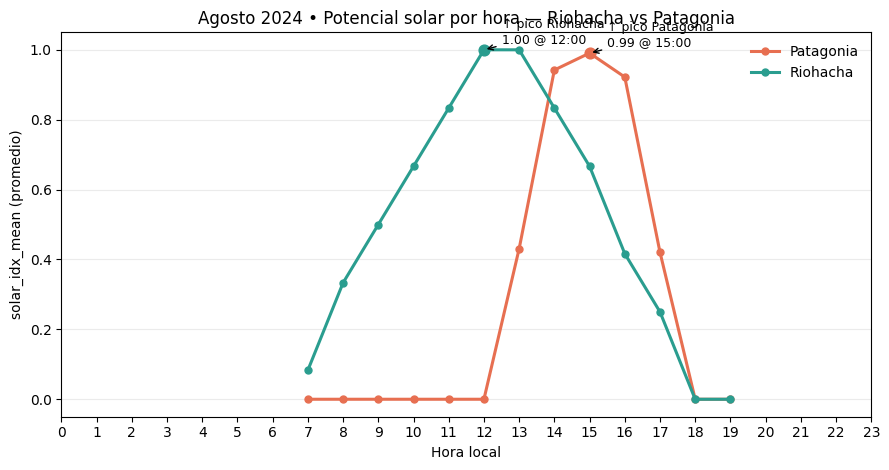

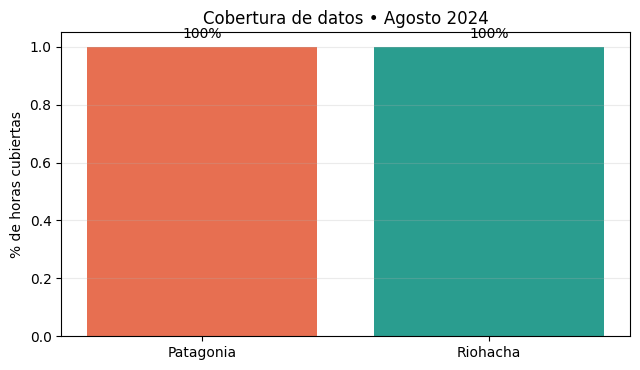

,city,obs_days,target_days,hours_coverage_pct,coverage_quality
0,Patagonia,31,31,100%,good
1,Riohacha,31,31,100%,good


In [5]:
# === Solar • Agosto 2024 (Patagonia vs Riohacha)  ===
# --------- Config ----------
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE = f"s3://{BUCKET}/openweather/answers/q1_solar_hour_by_month"
CITIES = ["Patagonia", "Riohacha"]
YEAR = 2024
MONTH = 8  # Agosto

# Paleta por ciudad
PALETTE = {
    "Patagonia": "#e76f51",  # terracota
    "Riohacha":  "#2a9d8f",  # verde azulado
}

# --------- Carga ----------
frames = []
for city in CITIES:
    path = f"{BASE}/city_name={city}/year={YEAR}/month={MONTH}/"
    df = pd.read_parquet(path)
    df["city"] = city
    frames.append(df[[
        "city", "local_hour",
        "solar_idx_mean", "avg_clouds", "precip_1h_mean",
        "obs_days","target_days","hours_coverage_pct","coverage_quality"
    ]])

aug = pd.concat(frames, ignore_index=True)
aug["local_hour"] = aug["local_hour"].astype(int)

# --------- Tabla estilizada ----------
tbl = (aug.pivot_table(index="local_hour",
                       columns="city",
                       values="solar_idx_mean",
                       aggfunc="mean")
         .sort_index())
tbl.columns = [f"{c} (solar_idx)" for c in tbl.columns]

# Horas altas de potencial
styled = (tbl.style
          .set_caption("Agosto 2024 • Potencial solar por hora (solar_idx_mean)")
          .format("{:.3f}")
          .background_gradient(axis=None, cmap="YlOrRd"))  # más caliente = más intenso
display(styled)

# --------- Gráfica por hora ----------
plt.figure(figsize=(9,4.8))
for city in CITIES:
    series = tbl[f"{city} (solar_idx)"] if f"{city} (solar_idx)" in tbl.columns else None
    if series is None:
        continue
    plt.plot(series.index, series.values,
             label=city,
             marker="o", linewidth=2.2, markersize=5,
             color=PALETTE.get(city, None))

    # Anota el pico por ciudad
    if len(series) > 0:
        peak_h = int(series.idxmax())
        peak_v = float(series.max())
        plt.scatter([peak_h], [peak_v], s=60, zorder=3, color=PALETTE.get(city, None))
        plt.annotate(
            f"↑ pico {city}\n{peak_v:.2f} @ {peak_h}:00",
            xy=(peak_h, peak_v),
            xytext=(peak_h+0.5, peak_v+0.02),
            arrowprops=dict(arrowstyle="->", lw=1),
            fontsize=9
        )

plt.title("Agosto 2024 • Potencial solar por hora — Riohacha vs Patagonia")
plt.xlabel("Hora local")
plt.ylabel("solar_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, which="major", axis="y", alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --------- Cobertura, calidad de datos ----------
cov = (aug.groupby("city", as_index=False)
          .agg(obs_days=("obs_days","max"),
               target_days=("target_days","max"),
               hours_coverage_pct=("hours_coverage_pct","max"),
               coverage_quality=("coverage_quality","max")))

# Barras de cobertura (porcentaje)
plt.figure(figsize=(6.5,3.8))
bars = plt.bar(cov["city"], cov["hours_coverage_pct"],
               color=[PALETTE.get(c, None) for c in cov["city"]])
plt.title("Cobertura de datos • Agosto 2024")
plt.ylabel("% de horas cubiertas")
plt.ylim(0, 1.05)
plt.grid(True, axis="y", alpha=0.25)

# Etiquetas sobre cada barra
for b, p in zip(bars, cov["hours_coverage_pct"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.02,
             f"{p:.0%}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# Vista de la tabla de cobertura (con formato legible)
display(
    cov.style
       .set_caption("Cobertura de datos • Agosto 2024")
       .format({"hours_coverage_pct": "{:.0%}"})
)


RESULTADO:
* Riohacha (agosto 2024): el potencial arranca desde 07:00, crece hasta un pico ~1.00 a las 12:00–13:00, y desciende hacia las 17:00.
Ventana útil ≈ 10:00–15:00 (≥0.5, ~6 h), con curva ancha y simétrica.

* Patagonia (agosto 2024): comienza más tarde (invierno austral), prácticamente nulo hasta ~12:00, pico ~0.99 a las 15:00, y cae a ~18:00.
Ventana útil ≈ 14:00–16:00 (≥0.5, ~3 h), pico estrecho y desplazado a la tarde.

* Cobertura: ambas ciudades con 100% de horas, se muestra una comparación sólida.

**● Q2 ¿Qué patrones históricos se observan en el potencial eólico de ambas ubicaciones?**

1. Compara el promedio horario del potencial eólico y el índice de viento (wind_idx_mean, 0–1) por ciudad.
2. Identifica horas pico, ventana útil (bloques de horas con viento alto), forma del ciclo diurno.
3. La gráfica de cobertura indica si la comparación es confiable. Si las barras están en 100%, puedes comparar sin sesgos. Si <100%, aclara que se usan solo horas observadas.

,Patagonia (W/m²),Riohacha (W/m²)
local_hour,,
0,32.14,31.13
1,29.77,30.00
2,27.70,30.58
3,24.45,31.01
4,25.26,32.63
5,24.04,28.46
6,22.37,17.56
7,22.19,14.00
8,18.93,40.53


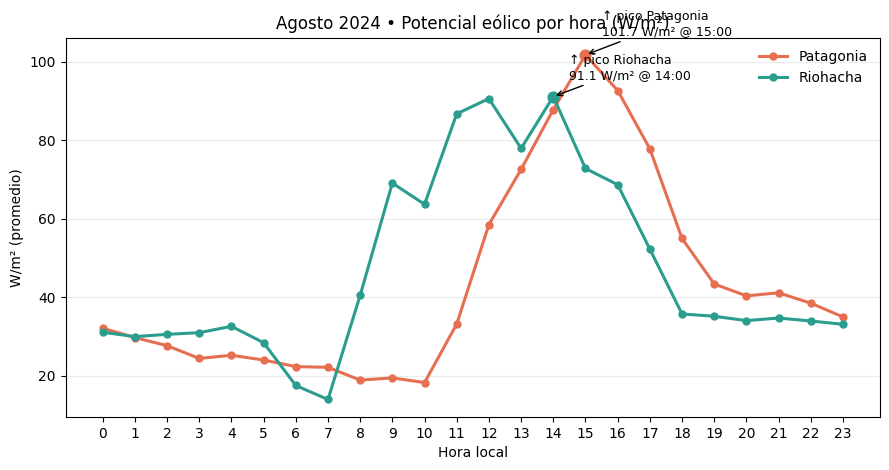

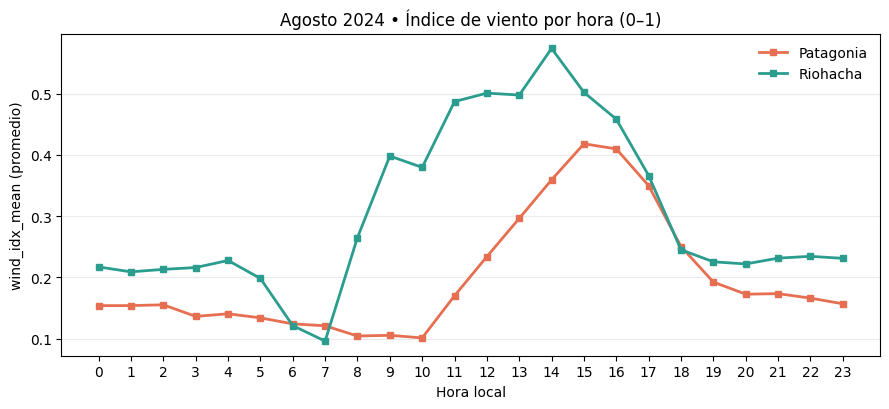

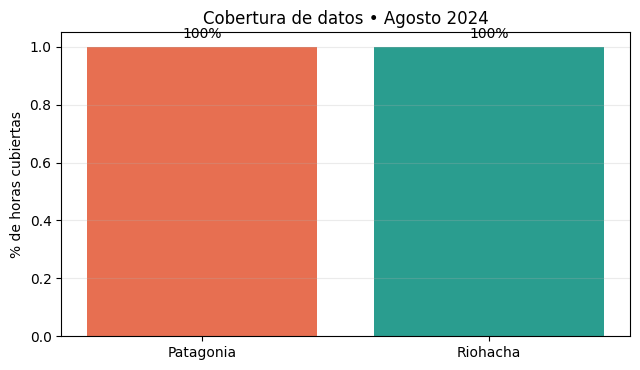

,city,obs_days,target_days,hours_coverage_pct,coverage_quality
0,Patagonia,31,31,100%,good
1,Riohacha,31,31,100%,good


In [6]:
# === Eólico • Agosto 2024 (Patagonia vs Riohacha) ===
# --------- Config ----------
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE = f"s3://{BUCKET}/openweather/answers/q2_wind_patterns"
CITIES = ["Patagonia", "Riohacha"]
YEAR = 2024
MONTH = 8  # Agosto

# Paleta por ciudad
PALETTE = {
    "Patagonia": "#e76f51",
    "Riohacha":  "#2a9d8f",
}

# --------- Carga ----------
frames = []
for city in CITIES:
    path = f"{BASE}/city_name={city}/year={YEAR}/month={MONTH}/"
    df = pd.read_parquet(path)
    df["city"] = city
    frames.append(df[[
        "city","local_hour",
        "wind_power_wm2_mean","wind_idx_mean",
        "obs_days","target_days","hours_coverage_pct","coverage_quality"
    ]])

aug = pd.concat(frames, ignore_index=True)
aug["local_hour"] = aug["local_hour"].astype(int)

# --------- Tabla estilizada (W/m²) ----------
tbl_power = (aug.pivot_table(index="local_hour",
                             columns="city",
                             values="wind_power_wm2_mean",
                             aggfunc="mean")
               .sort_index())
tbl_power.columns = [f"{c} (W/m²)" for c in tbl_power.columns]

styled = (tbl_power.style
          .set_caption("Agosto 2024 • Potencial eólico por hora (W/m² promedio)")
          .format("{:.2f}")
          .background_gradient(axis=None, cmap="PuBuGn"))
display(styled)

# --------- Gráfica por hora (W/m²) con pico anotado ----------
plt.figure(figsize=(9,4.8))
for city in CITIES:
    col = f"{city} (W/m²)"
    if col not in tbl_power.columns:
        continue
    series = tbl_power[col]
    plt.plot(series.index, series.values,
             label=city, marker="o", linewidth=2.2, markersize=5,
             color=PALETTE.get(city, None))

    # PICO por ciudad
    if len(series) > 0:
        peak_h = int(series.idxmax())
        peak_v = float(series.max())
        plt.scatter([peak_h], [peak_v], s=60, zorder=3, color=PALETTE.get(city, None))
        plt.annotate(
            f"↑ pico {city}\n{peak_v:.1f} W/m² @ {peak_h}:00",
            xy=(peak_h, peak_v),
            xytext=(peak_h+0.5, peak_v*1.05),
            arrowprops=dict(arrowstyle="->", lw=1),
            fontsize=9
        )

plt.title("Agosto 2024 • Potencial eólico por hora (W/m²)")
plt.xlabel("Hora local")
plt.ylabel("W/m² (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, which="major", axis="y", alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --------- Gráfica por hora del índice eólico (0–1) ----------
tbl_idx = (aug.pivot_table(index="local_hour",
                           columns="city",
                           values="wind_idx_mean",
                           aggfunc="mean")
             .sort_index())
tbl_idx.columns = [f"{c} (idx)" for c in tbl_idx.columns]

plt.figure(figsize=(9,4.2))
for city in CITIES:
    col = f"{city} (idx)"
    if col not in tbl_idx.columns:
        continue
    series = tbl_idx[col]
    plt.plot(series.index, series.values,
             label=city, marker="s", linewidth=2.0, markersize=5,
             color=PALETTE.get(city, None))

plt.title("Agosto 2024 • Índice de viento por hora (0–1)")
plt.xlabel("Hora local")
plt.ylabel("wind_idx_mean (promedio)")
plt.xticks(range(0,24,1))
plt.grid(True, which="major", axis="y", alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --------- Cobertura (para calidad de datos) ----------
cov = (aug.groupby("city", as_index=False)
          .agg(obs_days=("obs_days","max"),
               target_days=("target_days","max"),
               hours_coverage_pct=("hours_coverage_pct","max"),
               coverage_quality=("coverage_quality","max")))

plt.figure(figsize=(6.5,3.8))
bars = plt.bar(cov["city"], cov["hours_coverage_pct"],
               color=[PALETTE.get(c, None) for c in cov["city"]])
plt.title("Cobertura de datos • Agosto 2024")
plt.ylabel("% de horas cubiertas")
plt.ylim(0, 1.05)
plt.grid(True, axis="y", alpha=0.25)

for b, p in zip(bars, cov["hours_coverage_pct"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.02,
             f"{p:.0%}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

display(
    cov.style
       .set_caption("Cobertura de datos • Agosto 2024")
       .format({"hours_coverage_pct": "{:.0%}"})
)


RESULTADO:

* Riohacha muestra un pico alrededor de 14:00 con ≈ 91 W/m²; el índice alcanza ≈ 0.57 hacia 15:00. Ventana útil amplia: 11:00–16:00 con valores altos y tramo relativamente suave y sostenido. Madrugada/noche se mantiene en ~30–40 W/m², lo que sugiere recurso moderado fuera del pico.

* Patagonia nuestra un pico más tarde, ~15:00, con ≈ 102 W/m². Ventana útil más estrecha: 14:00–17:00; rampa rápida desde el mediodía y descenso hacia el atardecer.Madrugada con ~18–30 W/m² y noches de ~30–40 W/m²; mayor amplitud diurna que en Riohacha.

* Cobertura: Ambas ciudades 100% lo cual indica que las conclusiones arriba son confiables para agosto.


**●	Q3 ¿Qué condiciones climáticas están asociadas con reducciones significativas en el potencial renovable?**

1. Calcula, por condición meteorológica (weather_main) y ciudad, la diferencia del RPS (potencial renovable) respecto al promedio del mes (Δ% RPS).
2. Filtra condiciones con ≥ 24 h observadas (robustez) “al menos un día de datos” repartidos en el mes. Y marca si la reducción es estadísticamente consistente (rps_reduction_confident).
3. Δ% RPS < 0 indica peor que el promedio del mes (reduce el potencial)
4. ✅ en “Veredicto” significa reducción con evidencia.
5. El comparativo te dice si la misma condición afecta igual en ambas ciudades.

In [7]:
# === Q3 • Condiciones que REDUCEN el potencial renovable ===
# -------- Configuración --------
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE   = f"s3://{BUCKET}/openweather/answers/q3_weather_main"
CITIES = ["Patagonia", "Riohacha"]
YEAR, MONTH = 2024, 8
MIN_HOURS = 24  # mínimo de horas para considerar una condición

# -------- Carga --------
frames = []
for city in CITIES:
    path = f"{BASE}/city_name={city}/year={YEAR}/month={MONTH}/"
    df = pd.read_parquet(path)
    df["city"] = city
    frames.append(df[[
        "city","weather_main","n_hours","n_days",
        "rps_mean","rps_baseline","rps_delta","rps_delta_pct",
        "rps_ci_low","rps_ci_high",
        "rps_drop_confident","rps_reduction_flag","rps_reduction_confident"
    ]])

q3 = pd.concat(frames, ignore_index=True)

# -------- Helpers --------
def verdict(delta_pct, confident):
    if delta_pct < -0.1:
        return "↓ reduce (✅)" if bool(confident) else "↓ reduce (⚠️)"
    elif delta_pct > 0.1:
        return "↑ aumenta"
    else:
        return "≈ neutro"

def style_city_table(df, title):
    # Δ% con gradiente y Horas con barra
    sty = (
        df.style
          .set_caption(title)
          .format({"Δ% RPS":"{:+.1f}", "Horas":"{:,.0f}", "Días":"{:,.0f}"})
          .background_gradient(subset=["Δ% RPS"], cmap="RdYlGn_r")
          .bar(subset=["Horas"], color="#9ecae1", vmin=0)
    )

    sty = sty.set_properties(subset=["Δ% RPS", "Horas"], **{"color": "black", "font-weight": "600"})
    return sty

def classify_row(row, thr=0.1):
    p = row.get("Patagonia Δ% RPS"); r = row.get("Riohacha Δ% RPS")
    red_p = (pd.notna(p) and p < -thr)
    red_r = (pd.notna(r) and r < -thr)
    inc   = ((pd.notna(p) and p > thr) or (pd.notna(r) and r > thr))
    if red_p and red_r: return "Reduce en ambas"
    if red_p:           return "Reduce en Patagonia"
    if red_r:           return "Reduce en Riohacha"
    if inc:             return "Aumenta"
    return "Neutro"

def style_compare_table(df, title):
    sty = (
        df.style
          .set_caption(title)
          .format({"Patagonia Δ% RPS":"{:+.1f}", "Riohacha Δ% RPS":"{:+.1f}"})
          .background_gradient(subset=["Patagonia Δ% RPS"], cmap="RdYlGn_r")
          .background_gradient(subset=["Riohacha Δ% RPS"], cmap="RdYlGn_r")
    )

    colors = {
        "Reduce en ambas":"background-color:#f4a261",
        "Reduce en Patagonia":"background-color:#f4d2a5",
        "Reduce en Riohacha":"background-color:#f4d2a5",
        "Aumenta":"background-color:#b7e4c7",
        "Neutro":"background-color:#dee2e6",
    }
    def color_class(col):
        return [colors.get(v, "") for v in col]
    sty = sty.apply(color_class, subset=["Clasificación"])

    sty = sty.set_properties(
        subset=["Patagonia Δ% RPS", "Riohacha Δ% RPS", "Clasificación"],
        **{"color": "black", "font-weight": "600"}
    )
    return sty

# -------- Limpieza --------
clean = q3[q3["n_hours"] >= MIN_HOURS].copy()
clean["Condición"]  = clean["weather_main"].astype(str)
clean["Horas"]      = clean["n_hours"].astype(int)
clean["Días"]       = clean["n_days"].astype(int)
clean["Δ% RPS"]     = clean["rps_delta_pct"].astype(float)
clean["Veredicto"]  = [verdict(x, c) for x, c in zip(clean["Δ% RPS"], clean["rps_reduction_confident"])]
clean["Confianza"]  = clean["rps_reduction_confident"].astype(bool)

display(Markdown("**Leyenda rápida:** Δ% RPS < 0 ⇒ reducción del potencial. ✅ evidencia estadística · ⚠️ señal no concluyente · "
                 f"Se muestran condiciones con ≥{MIN_HOURS} h observadas."))

# -------- Vista por ciudad (ordenado por mayor reducción) --------
for city in CITIES:
    sub = (clean[clean["city"]==city]
           .sort_values("Δ% RPS")  # más negativo primero
           [["Condición","Horas","Días","Δ% RPS","Veredicto","Confianza"]])
    display(style_city_table(sub, f"{city} • Agosto {YEAR} — Condiciones (≥{MIN_HOURS} h) ordenadas por reducción"))

# -------- Comparativo lado a lado (Δ% RPS por condición) --------
pt = clean.pivot_table(index="Condición", columns="city", values="Δ% RPS", aggfunc="mean")
pt.columns = [f"{c} Δ% RPS" for c in pt.columns]
pt.columns.name = None
pivot = pt.reset_index()

# Clasificación por condición y orden
pivot["Clasificación"] = pivot.apply(classify_row, axis=1)
min_delta = pivot[[f"{c} Δ% RPS" for c in CITIES]].min(axis=1, skipna=True)
pivot = pivot.assign(_ord=min_delta).sort_values(["Clasificación","_ord"]).drop(columns=["_ord"])

display(style_compare_table(pivot, f"Comparativo Δ% RPS por condición — Agosto {YEAR}"))



**Leyenda rápida:** Δ% RPS < 0 ⇒ reducción del potencial. ✅ evidencia estadística · ⚠️ señal no concluyente · Se muestran condiciones con ≥24 h observadas.

,Condición,Horas,Días,Δ% RPS,Veredicto,Confianza
2,Clear,229,24,-34.6,↓ reduce (✅),True
3,Clouds,452,29,+9.3,↑ aumenta,False
0,Rain,48,10,+70.4,↑ aumenta,False


,Condición,Horas,Días,Δ% RPS,Veredicto,Confianza
8,Clear,78,24,-19.7,↓ reduce (✅),True
7,Rain,120,25,-6.3,↓ reduce (⚠️),False
4,Clouds,535,31,+3.2,↑ aumenta,False


,Condición,Patagonia Δ% RPS,Riohacha Δ% RPS,Clasificación
1,Clouds,+9.3,+3.2,Aumenta
2,Rain,+70.4,-6.3,Reduce en Riohacha
0,Clear,-34.6,-19.7,Reduce en ambas


RESULTADOS:
* Patagonia:

  - Clear: −34.6% (✅). Reducción significativa.
  - Rain: +70.4% (⚠️, no concluyente). Aumenta en el agregado de agosto.
  - Clouds: +9.3% (⚠️). Ligero aumento.

* Riohacha

  - Clear: −19.7% (✅). Reducción significativa.
  - Rain: −6.3% (⚠️). Reducción leve, no concluyente.
  - Clouds: +3.2% (⚠️). Efecto leve al alza.

* Comparativo:

  - Clear: reduce en ambas (efecto más fuerte en Patagonia).
  - Rain: Reduce solo en Riohacha (en Patagonia sale positivo en agosto, probablemente por viento asociado a sistemas lluviosos).
  - Clouds: Aumenta levemente en ambas (no concluyente).

**● Q4	¿Cómo se comportan las predicciones meteorológicas en comparación con las condiciones observadas en el pasado reciente?**


1. Gráfico de líneas: dos series (hoy vs. año pasado); las ❌ marcan días con cobertura baja.
2. Compara, para cada ciudad y cada día listado, el potencial renovable estimado “hoy” (rps_today) con el observado el mismo día del año pasado (rps_last_year).
3. La columna coverage_quality indica si la comparación diaria es confiable

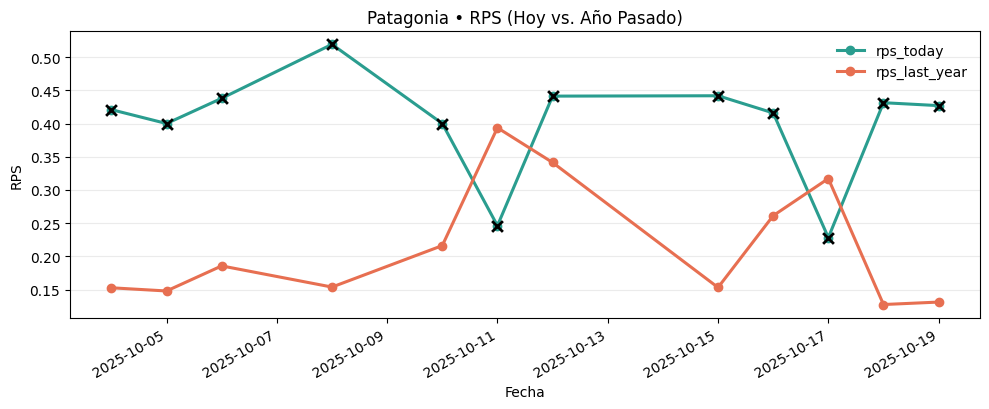

,date,rps_today,rps_last_year,diff_pct,coverage_quality,analysis_note
0,2025-10-04,0.421,0.153,+175.7%,low,Cobertura diaria baja hoy; comparación poco confiable.
1,2025-10-05,0.400,0.148,+170.6%,low,Cobertura diaria baja hoy; comparación poco confiable.
2,2025-10-06,0.438,0.186,+136.0%,low,Cobertura diaria baja hoy; comparación poco confiable.
3,2025-10-08,0.519,0.154,+237.8%,low,Cobertura diaria baja hoy; comparación poco confiable.
4,2025-10-10,0.400,0.216,+85.0%,low,Cobertura diaria baja hoy; comparación poco confiable.
5,2025-10-11,0.246,0.394,-37.5%,low,Cobertura diaria baja hoy; comparación poco confiable.
6,2025-10-12,0.441,0.341,+29.3%,low,Cobertura diaria baja hoy; comparación poco confiable.
7,2025-10-15,0.442,0.153,+188.6%,low,Cobertura diaria baja hoy; comparación poco confiable.
8,2025-10-16,0.416,0.261,+59.2%,low,Cobertura diaria baja hoy; comparación poco confiable.
9,2025-10-17,0.228,0.317,-28.0%,low,Cobertura diaria baja hoy; comparación poco confiable.


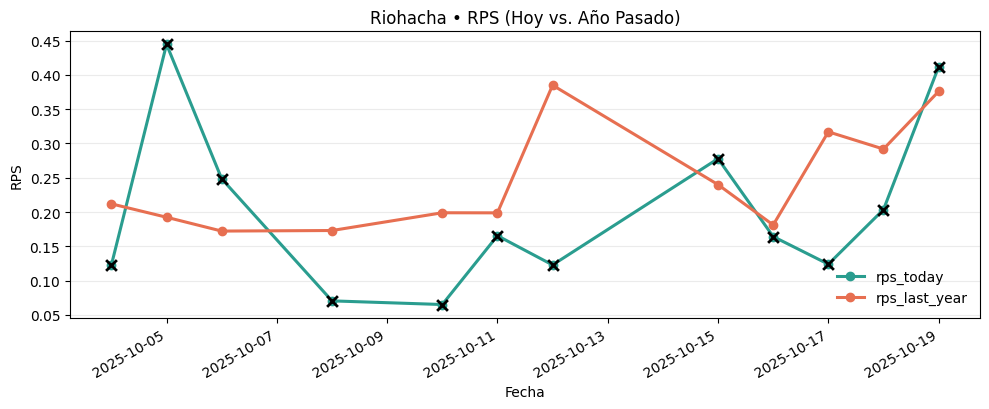

,date,rps_today,rps_last_year,diff_pct,coverage_quality,analysis_note
0,2025-10-04,0.123,0.212,-42.1%,low,Cobertura diaria baja hoy; comparación poco confiable.
1,2025-10-05,0.444,0.192,+130.9%,low,Cobertura diaria baja hoy; comparación poco confiable.
2,2025-10-06,0.248,0.172,+44.2%,low,Cobertura diaria baja hoy; comparación poco confiable.
3,2025-10-08,0.071,0.173,-59.2%,low,Cobertura diaria baja hoy; comparación poco confiable.
4,2025-10-10,0.065,0.199,-67.2%,low,Cobertura diaria baja hoy; comparación poco confiable.
5,2025-10-11,0.166,0.199,-16.8%,low,Cobertura diaria baja hoy; comparación poco confiable.
6,2025-10-12,0.123,0.385,-68.1%,low,Cobertura diaria baja hoy; comparación poco confiable.
7,2025-10-15,0.278,0.240,+15.8%,low,Cobertura diaria baja hoy; comparación poco confiable.
8,2025-10-16,0.164,0.181,-9.3%,low,Cobertura diaria baja hoy; comparación poco confiable.
9,2025-10-17,0.124,0.317,-60.9%,low,Cobertura diaria baja hoy; comparación poco confiable.


In [8]:
# === Q4 • Predicciones vs Observado (Patagonia & Riohacha)
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE   = f"s3://{BUCKET}/openweather/answers/q4_today_vs_last_year"
CITIES = ["Patagonia", "Riohacha"]

# —— días (YYYY-MM-DD) ——
DATES = [
    "2025-10-04","2025-10-05","2025-10-06","2025-10-08",
    "2025-10-10","2025-10-11","2025-10-12","2025-10-15",
    "2025-10-16","2025-10-17","2025-10-18","2025-10-19",
]
DATES = [pd.to_datetime(d).date() for d in DATES]

# —— Carga ——
frames = []
for city in CITIES:
    for d in DATES:
        path = f"{BASE}/date={pd.Timestamp(d).strftime('%Y-%m-%d')}/city_name={city}/"
        try:
            df = pd.read_parquet(path)
            df["city"] = city
            df["date"] = pd.to_datetime(d)
            frames.append(df[[
                "date","city","rps_today","rps_last_year","diff_pct",
                "coverage_quality","analysis_note"
            ]])
        except Exception:
            pass

if not frames:
    raise SystemExit("No hay datos para los días listados. Verifica rutas en S3.")

q4 = (pd.concat(frames, ignore_index=True)
        .sort_values(["city","date"])
        .reset_index(drop=True))

# —— Paleta para el gráfico ——
PALETTE = {
    "rps_today": "#2a9d8f",
    "rps_last_year": "#e76f51",
}

# —— Tabla estilizada  ——
def style_city_table(df, title):
    sty = (
        df.style
          .set_caption(title)
          .format({
              "date": lambda x: pd.to_datetime(x).strftime("%Y-%m-%d"),
              "rps_today":"{:.3f}",
              "rps_last_year":"{:.3f}",
              "diff_pct":"{:+.1f}%",
          })
          .background_gradient(subset=["diff_pct"], cmap="RdYlGn")  # rojo<0, verde>0
    )
    # Resaltar cobertura
    colors = {
        "good":   "background-color:#b7e4c7; color:black; font-weight:600;",
        "ok":     "background-color:#ffe8a1; color:black; font-weight:600;",
        "low":    "background-color:#f8d7da; color:black; font-weight:600;",
        "missing":"background-color:#e9ecef; color:black; font-weight:600;",
    }
    def cov_style(col):
        return [colors.get(str(v).lower(), "") for v in col]
    sty = sty.apply(cov_style, subset=["coverage_quality"])
    sty = sty.set_properties(subset=["diff_pct","coverage_quality"], **{"color":"black","font-weight":"600"})
    return sty


for city in CITIES:
    sub = (q4[q4["city"]==city]
             .sort_values("date")
             .groupby("date", as_index=False).first())  # 1 fila por día

    # 1) rps_today vs rps_last_year
    plt.figure(figsize=(10,4.2))
    plt.plot(sub["date"], sub["rps_today"],     marker="o", linewidth=2.2, label="rps_today",     color=PALETTE["rps_today"])
    plt.plot(sub["date"], sub["rps_last_year"], marker="o", linewidth=2.2, label="rps_last_year", color=PALETTE["rps_last_year"])
    # marcar cobertura baja o faltante con X
    for x, y, qual in zip(sub["date"], sub["rps_today"], sub["coverage_quality"]):
        if str(qual).lower() in {"low","missing"} and not pd.isna(y):
            plt.scatter([x], [y], marker="x", s=60, linewidths=2, color="black", zorder=3)
    plt.title(f"{city} • RPS (Hoy vs. Año Pasado)")
    plt.xlabel("Fecha"); plt.ylabel("RPS")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.25)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


    tidy = sub[["date","rps_today","rps_last_year","diff_pct","coverage_quality","analysis_note"]].copy()
    display(style_city_table(tidy, f"{city} • Hoy vs. año pasado (solo días listados)"))


RESULTADOS:

* Patagonia superó el desempeño del año pasado en 10/12 días se observan picos > +200%, con dos caídas puntuales el 11 y 17 Oct con -37.5 y .28 % respectivamente.
* Riohacha tuvo 4/12 días por encima se observan picos > +100% y 8/12 por debajo del año pasado, con alta variabilidad diaria.
* En ambos casos, la calidad de cobertura diaria fue baja, por lo que estas comparaciones se interpretan como tendencias indicativas y requieren confirmación con más datos o una ventana temporal más amplia.

**● Q5	¿Cuáles fueron los días con mayor y menor potencial energético en cada ubicación durante el periodo de análisis?**

1. Verde/rojo en rps_day (potencial energético) significa mejores/peores días.
2. daylight_hours (barra) muestra si la duración del día influyó.
3. coverage_quality (verde “good”) valida que los días son comparables.

### Q5 • Mejores y peores días — Agosto 2024

,date,rps_day,solar_idx_day,wind_idx_day,daylight_hours,clouds_avg,precip_sum,max_temp,min_temp,coverage_quality
0,2024-08-10,0.556,0.292,0.779,13.0,41%,0.0,6.8,2.6,good
1,2024-08-11,0.553,0.279,0.554,13.0,13%,0.0,7.3,-0.2,good
2,2024-08-03,0.518,0.288,0.693,13.0,24%,0.4,6.1,1.1,good
3,2024-08-02,0.515,0.261,0.597,13.0,68%,0.0,9.7,3.6,good
4,2024-08-01,0.320,0.272,0.391,13.0,95%,2.9,10.0,2.5,good


,date,rps_day,solar_idx_day,wind_idx_day,daylight_hours,clouds_avg,precip_sum,max_temp,min_temp,coverage_quality
10,2024-08-22,0.111,0.300,0.021,13.0,57%,1.6,4.1,-4.0,good
11,2024-08-08,0.112,0.288,0.036,13.0,28%,0.0,8.1,-3.4,good
12,2024-08-16,0.114,0.304,0.031,13.0,1%,0.0,7.2,-4.5,good
13,2024-08-15,0.119,0.292,0.048,13.0,9%,0.3,7.1,-2.3,good
14,2024-08-17,0.119,0.300,0.050,13.0,11%,0.0,5.2,-3.3,good


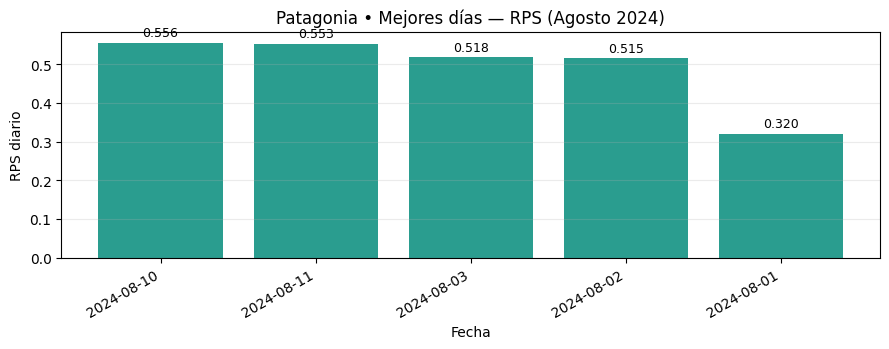

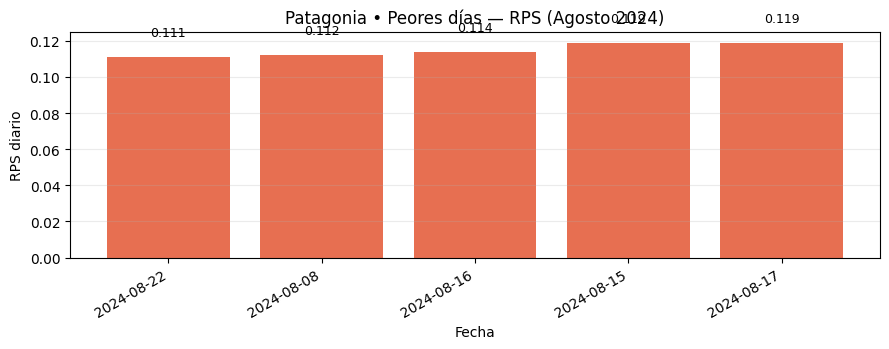

,date,rps_day,solar_idx_day,wind_idx_day,daylight_hours,clouds_avg,precip_sum,max_temp,min_temp,coverage_quality
5,2024-08-05,0.670,0.506,0.724,13.0,54%,0.6,32.0,27.6,good
6,2024-08-20,0.643,0.506,0.741,13.0,44%,0.5,34.7,28.4,good
7,2024-08-29,0.641,0.506,0.678,13.0,30%,0.0,33.9,27.9,good
8,2024-08-21,0.620,0.506,0.727,13.0,48%,0.0,33.3,28.3,good
9,2024-08-09,0.490,0.506,0.575,13.0,21%,0.0,32.6,27.1,good


,date,rps_day,solar_idx_day,wind_idx_day,daylight_hours,clouds_avg,precip_sum,max_temp,min_temp,coverage_quality
15,2024-08-27,0.187,0.506,0.055,13.0,73%,0.2,30.3,25.9,good
16,2024-08-02,0.199,0.506,0.080,13.0,68%,2.1,30.0,26.0,good
17,2024-08-14,0.200,0.506,0.082,13.0,65%,4.9,30.6,26.8,good
18,2024-08-15,0.208,0.506,0.098,13.0,52%,0.1,31.8,27.4,good
19,2024-08-07,0.218,0.506,0.099,13.0,72%,11.5,29.6,26.0,good


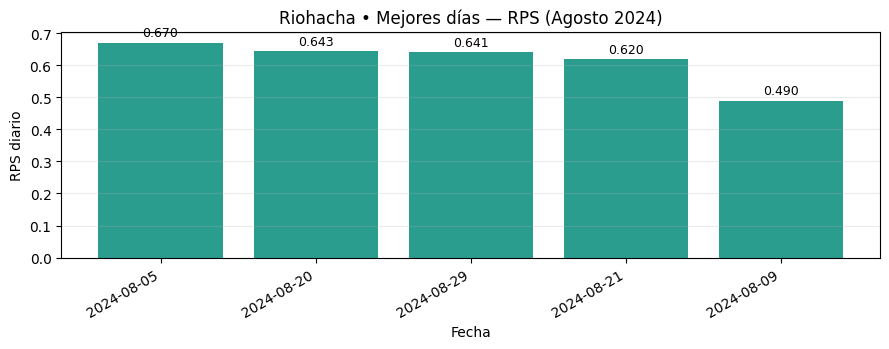

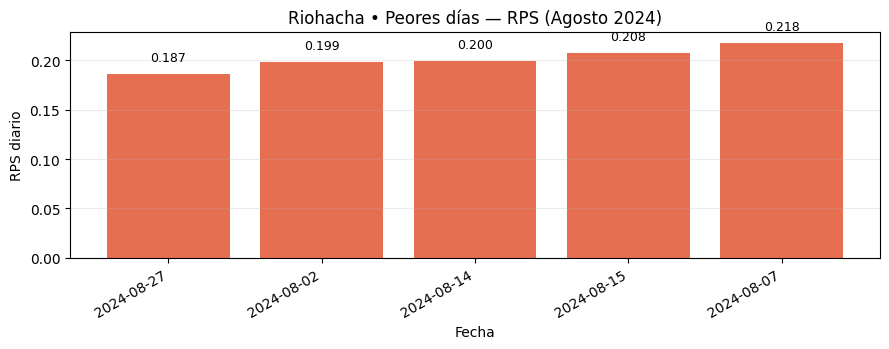

In [9]:
# === Q5 • Mejores y peores días===
# -------- Configuración --------
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE = f"s3://{BUCKET}/openweather/answers"
CITIES = ["Patagonia", "Riohacha"]
YEAR, MONTH = 2024, 8

PALETTE = {"best": "#2a9d8f", "worst": "#e76f51"}

def load_q5(kind: str):
    frames = []
    for city in CITIES:
        path = f"{BASE}/{kind}/city_name={city}/year={YEAR}/month={MONTH}/"
        df = pd.read_parquet(path)
        df["city"] = city
        df["kind"] = "best" if "best" in kind else "worst"
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# -------- Carga --------
best  = load_q5("q5_best_days_topk")
worst = load_q5("q5_worst_days_topk")
q5 = pd.concat([best, worst], ignore_index=True)

# Campos y nombres amigables
cols = ["event_date","city","rps_day","solar_idx_day","wind_idx_day",
        "hours_observed_daylight","avg_clouds","precip_1d_sum",
        "max_temp","min_temp","coverage_quality","kind"]
q5 = q5[cols].rename(columns={
    "event_date":"date",
    "hours_observed_daylight":"daylight_hours",
    "avg_clouds":"clouds_avg",
    "precip_1d_sum":"precip_sum"
})
q5["date"] = pd.to_datetime(q5["date"]).dt.date

# --------- Estilos de tablas ---------
def style_table(df, title, kind):
    """
    kind: 'best' usa verde (Greens ↑ = mejor),
          'worst' usa rojo invertido (Reds_r ↑ = peor para valores bajos).
    """
    cmap = "Greens" if kind == "best" else "Reds_r"
    sty = (
        df.style
          .set_caption(title)
          .format({
              "date": lambda d: pd.to_datetime(d).strftime("%Y-%m-%d"),
              "rps_day": "{:.3f}",
              "solar_idx_day": "{:.3f}",
              "wind_idx_day": "{:.3f}",
              "daylight_hours": "{:.1f}",
              "clouds_avg": "{:.0f}%",
              "precip_sum": "{:.1f}",
              "max_temp": "{:.1f}",
              "min_temp": "{:.1f}",
          })
          .background_gradient(subset=["rps_day"], cmap=cmap)
          .bar(subset=["daylight_hours"], color="#9ecae1", vmin=0)
    )

    cov_colors = {
        "good":   "background-color:#b7e4c7; color:black; font-weight:600;",
        "ok":     "background-color:#ffe8a1; color:black; font-weight:600;",
        "low":    "background-color:#f8d7da; color:black; font-weight:600;",
    }
    def cov_style(col):
        return [cov_colors.get(str(v).lower(), "") for v in col]
    sty = sty.apply(cov_style, subset=["coverage_quality"])

    sty = sty.set_properties(subset=["rps_day","daylight_hours","coverage_quality"],
                             **{"color":"black","font-weight":"600"})
    return sty

# --------- Helper de gráfico ---------
def plot_ranked_bars(df, city, kind):
    title_kind = "Mejores" if kind == "best" else "Peores"
    asc = (kind == "worst")
    df = df.sort_values("rps_day", ascending=asc).copy()
    x = df["date"].astype(str)
    y = df["rps_day"].values

    plt.figure(figsize=(9,3.6))
    plt.bar(x, y, color=PALETTE[kind])
    for xi, yi in zip(x, y):
        plt.text(xi, yi + (0.01 if yi>=0 else -0.01),
                 f"{yi:.3f}", ha="center", va="bottom" if yi>=0 else "top", fontsize=9)
    plt.title(f"{city} • {title_kind} días — RPS (Agosto {YEAR})")
    plt.xlabel("Fecha"); plt.ylabel("RPS diario")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# ========= Salida por ciudad =========
display(Markdown(f"### Q5 • Mejores y peores días — Agosto {YEAR}"))
for city in CITIES:
    sub_best  = (q5[(q5["city"]==city) & (q5["kind"]=="best")]
                 .sort_values("rps_day", ascending=False))
    sub_worst = (q5[(q5["city"]==city) & (q5["kind"]=="worst")]
                 .sort_values("rps_day", ascending=True))

    # Tablas (paletas distintas)
    display(style_table(
        sub_best[["date","rps_day","solar_idx_day","wind_idx_day","daylight_hours",
                  "clouds_avg","precip_sum","max_temp","min_temp","coverage_quality"]],
        f"{city} • Mejores días (Agosto {YEAR}) — ordenado por RPS",
        kind="best"
    ))
    display(style_table(
        sub_worst[["date","rps_day","solar_idx_day","wind_idx_day","daylight_hours",
                   "clouds_avg","precip_sum","max_temp","min_temp","coverage_quality"]],
        f"{city} • Peores días (Agosto {YEAR}) — ordenado por RPS",
        kind="worst"
    ))

    # Gráficos
    plot_ranked_bars(sub_best,  city, "best")
    plot_ranked_bars(sub_worst, city, "worst")



RESULTADOS:

* Patagonia:
  - Mejor día: 2024-08-10 (rps_day ≈ 0.556), seguido de 08-11 (0.553).
  - En los mejores, wind_idx_day alto (0.78, 0.55, 0.69) y nubosidad baja-media.
  - Peor día: 2024-08-22 (rps_day ≈ 0.111)
  - Cobertura: good en todos los Top.

* Riohacha:
  - Mejor día: 2024-08-05 (rps_day ≈ 0.670), luego 08-20 (0.643).
  - Mejores días con wind_idx_day alto (0.72–0.74) y nubosidad moderada.
  - Peor día: 2024-08-27 (rps_day ≈ 0.187).
  - Brecha best-worst: +0.483 puntos (≈ 3.6×).
  - Cobertura: good en todos los Top.

**Q6 Sectores de viento TOP**

1. Resume, por ciudad, qué rumbos del viento (N, NE, W, etc) aportan más potencia media (wind_power_wm2_avg) y qué porcentaje de horas del mes vienen de cada sector (sector_hours_share).
2. Rosa energética (polar): paletas por rumbo; más largo = más potencia.
3. Barras horizontales: ranking de frecuencia (% de horas).

,Sector,Potencia prom (W/m²),% horas,Horas,Días
1,W,89.1,17.7%,132,18
4,N,69.3,10.8%,80,14
2,NW,35.0,17.7%,132,19
0,SW,28.4,26.1%,194,19
3,NE,24.8,11.3%,84,11


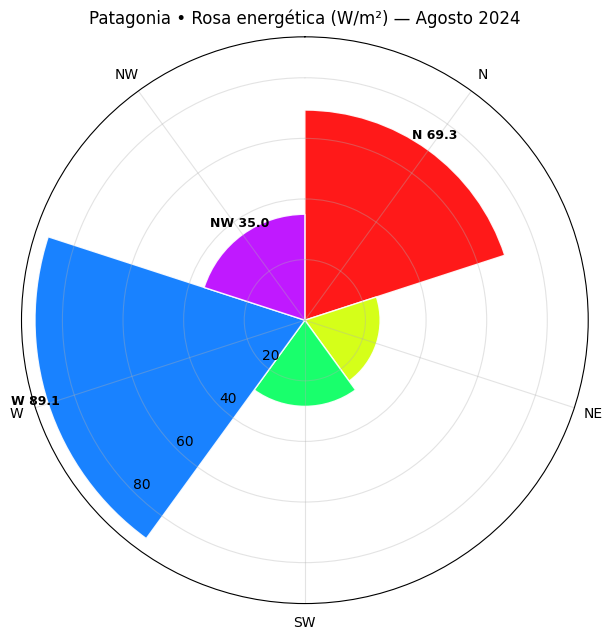

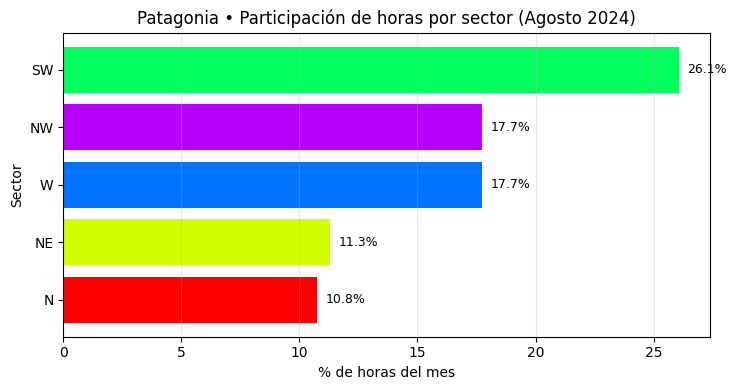

,Sector,Potencia prom (W/m²),% horas,Horas,Días
6,NE,65.2,17.7%,132,28
5,E,61.5,42.9%,319,29
7,N,36.4,16.1%,120,24
8,SE,12.4,9.4%,70,19
9,NW,12.0,4.2%,31,15


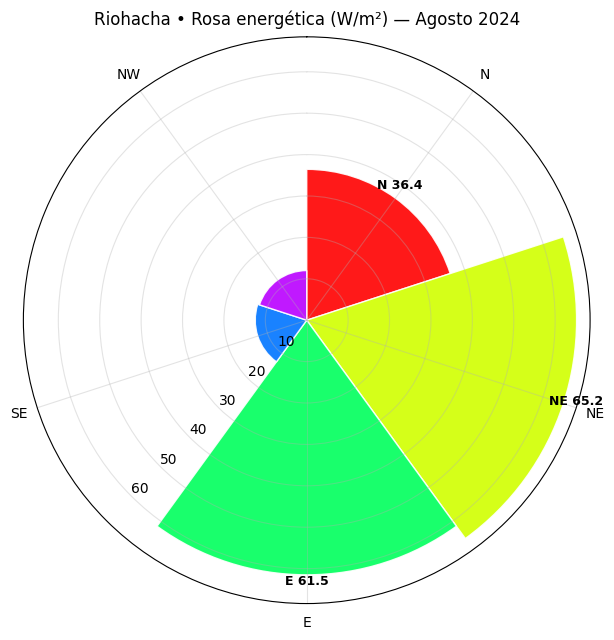

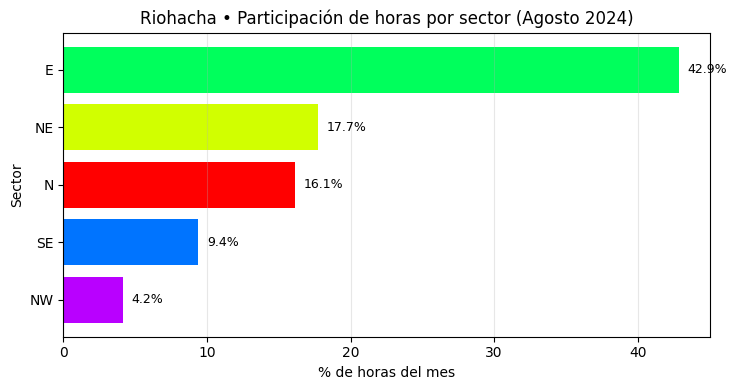

In [10]:
# === Q6 • Rosa energética y % horas por sector  ===
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE = f"s3://{BUCKET}/openweather/answers/q6_wind_sector_topk"
CITIES = ["Patagonia", "Riohacha"]
YEAR, MONTH = 2024, 8

SECTORS_16 = ["N","NNE","NE","ENE","E","ESE","SE","SSE",
              "S","SSW","SW","WSW","W","WNW","NW","NNW"]
SECTORS_8  = ["N","NE","E","SE","S","SW","W","NW"]

def angle_map(present):
    order = [s for s in SECTORS_16 if s in present] or [s for s in SECTORS_8 if s in present] or sorted(present)
    step = 2*np.pi/len(order)
    return {s:i*step for i,s in enumerate(order)}, order

def sector_palette(order):

    cmap = plt.cm.hsv
    return {s: cmap(i/len(order)) for i, s in enumerate(order)}

# --- cargar ---
dfs = []
for city in CITIES:
    path = f"{BASE}/city_name={city}/year={YEAR}/month={MONTH}/"
    try:
        df = pd.read_parquet(path)
        df["city"] = city
        dfs.append(df[["city","sector_name","n_hours","n_days","wind_power_wm2_avg","sector_hours_share"]])
    except Exception as e:
        print(f"{city}: no pude leer {path} -> {e}")

if not dfs:
    raise SystemExit("Sin datos Q6 para el mes indicado.")

q6 = pd.concat(dfs, ignore_index=True)

# --- helpers de estilo tabla ---
def style_sector_table(df, title):
    sty = (
        df.style
          .set_caption(title)
          .format({
              "Potencia prom (W/m²)": "{:.1f}",
              "% horas": "{:.1f}%",
              "Horas": "{:,.0f}",
              "Días": "{:,.0f}",
          })
          .background_gradient(subset=["Potencia prom (W/m²)"], cmap="YlOrRd")
          .bar(subset=["% horas"], color="#cfe8f3", vmin=0, vmax=100)
          .set_properties(subset=["Potencia prom (W/m²)","% horas"], **{"color":"black","font-weight":"600"})
    )
    return sty

# --- tablas + gráficas ---
for city in CITIES:
    sub = q6[q6["city"]==city].copy()
    if sub.empty:
        print(f"{city}: sin filas.")
        continue


    sub_tab = (
        sub.assign(**{"% horas": sub["sector_hours_share"]*100})
           .rename(columns={
               "sector_name":"Sector",
               "n_hours":"Horas",
               "n_days":"Días",
               "wind_power_wm2_avg":"Potencia prom (W/m²)",
           })
           .sort_values("Potencia prom (W/m²)", ascending=False)
           [["Sector","Potencia prom (W/m²)","% horas","Horas","Días"]]
    )
    display(style_sector_table(sub_tab, f"{city} • Agosto {YEAR} — Sectores (ordenado por potencia)"))

    # Orden/ángulos + colores consistentes
    present = sub["sector_name"].dropna().unique().tolist()
    ang_map, order = angle_map(present)
    colors = sector_palette(order)
    sub_ord = sub.set_index("sector_name").reindex(order).reset_index()

    # === Rosa energética (polar) ===
    theta = np.array([ang_map[s] for s in sub_ord["sector_name"]])
    r     = sub_ord["wind_power_wm2_avg"].to_numpy()
    width = np.repeat(2*np.pi/len(order), len(order))

    fig, ax = plt.subplots(subplot_kw={"projection":"polar"}, figsize=(6.5,6.5))
    ax.set_theta_zero_location("N")   # norte arriba
    ax.set_theta_direction(-1)        # sentido horario
    bars = ax.bar(theta, r, width=width, align="edge",
                  edgecolor="white", linewidth=1.0,
                  color=[colors[s] for s in sub_ord["sector_name"]], alpha=0.9)

    ax.set_xticks(theta + width/2)  # etiquetas centradas en cada sector
    ax.set_xticklabels(sub_ord["sector_name"])
    ax.set_rlabel_position(225)
    ax.grid(alpha=0.35)
    ax.set_title(f"{city} • Rosa energética (W/m²) — Agosto {YEAR}", va="bottom")

    # Anotar Top-3 por potencia
    top3 = sub_ord.nlargest(3, "wind_power_wm2_avg")
    for _, row in top3.iterrows():
        t = ang_map[row["sector_name"]] + width[0]/2
        rr = row["wind_power_wm2_avg"]
        ax.text(t, rr*1.05, f"{row['sector_name']} {rr:.1f}",
                ha="center", va="bottom", fontsize=9, weight="bold")

    plt.tight_layout()
    plt.show()

    # === Barras horizontales: % de horas (ordenado) ===
    sub_hours = sub_ord.assign(pct_hours=sub_ord["sector_hours_share"]*100)\
                       .sort_values("pct_hours", ascending=True)
    fig, ax = plt.subplots(figsize=(7.5,4))
    ax.barh(sub_hours["sector_name"], sub_hours["pct_hours"],
            color=[colors[s] for s in sub_hours["sector_name"]])
    for y, v in zip(sub_hours["sector_name"], sub_hours["pct_hours"]):
        ax.annotate(f"{v:.1f}%", (v, y), xytext=(6,0),
                    textcoords="offset points", va="center", ha="left", fontsize=9)
    ax.set_xlabel("% de horas del mes")
    ax.set_ylabel("Sector")
    ax.grid(axis="x", alpha=0.3)
    ax.set_title(f"{city} • Participación de horas por sector (Agosto {YEAR})")
    plt.tight_layout()
    plt.show()



RESULTADOS:

* Patagonia:
  - Top por potencia (W/m²):
    - W ~ 89.1 (muy alto)
    - N ~ 69.3
    - NW ~ 35.0 · SW ~ 28.4 · NE ~ 24.8

  - Top por % de horas:
    - SW ~ 26.1% (el más frecuente)
    - W ~ 17.7% · NW ~ 17.7% · NE ~ 11.3% · N ~ 10.8%

  - El Oeste (W) combina potencia muy alta y frecuencia media, y junto con N y SW explica gran parte del recurso. La rosa muestra un sector W muy marcado y N secundario.

* Riohacha:

  - Top por potencia (W/m²):
    - NE ~ 65.2
    - E ~ 61.5
    - N ~ 36.4 · SE ~ 12.4 · NW ~ 12.0

  - Top por % de horas:
    - E ~ 42.9% (claramente dominante)
    - NE ~ 17.7% · N ~ 16.1% · SE ~ 9.4% · NW ~ 4.2%

  - El Este (E) tiene muchísimas horas y buena potencia; NE suma potencia alta y frecuencia relevante.

**Q7 • Días más fríos y más calientes**

1. Tablas: arriba (días fríos), abajo (días calientes). El color en rps_day deja ver rápido si esos días fueron buenos/malos de potencial renovable.
2. coverage_quality para saber si la información es confiable.

,date,min_temp,rps_day,clouds_avg,precip_sum,coverage_quality
0,2024-08-24,-5.8,0.143,19%,0.0,good
1,2024-08-27,-4.6,0.182,22%,0.0,good
2,2024-08-16,-4.5,0.114,1%,0.0,good
3,2024-08-18,-4.2,0.159,49%,1.7,good
4,2024-08-22,-4.0,0.111,57%,1.6,good


,date,max_temp,rps_day,clouds_avg,precip_sum,coverage_quality
0,2024-08-31,14.4,0.140,54%,0.0,good
1,2024-08-30,13.8,0.153,11%,0.0,good
2,2024-08-12,13.7,0.123,90%,0.0,good
3,2024-08-13,12.2,0.136,82%,0.0,good
4,2024-08-09,12.1,0.204,76%,0.0,good


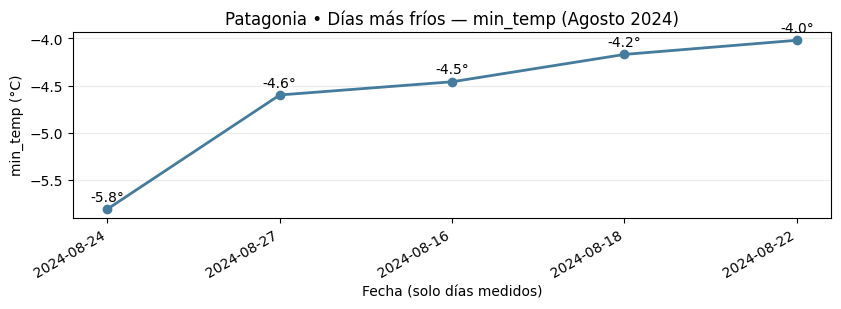

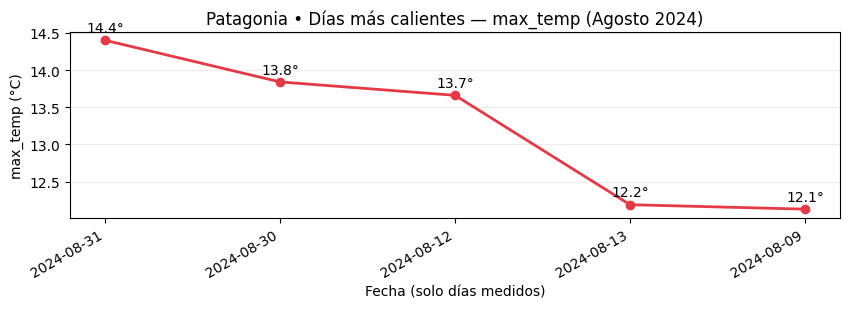

,date,min_temp,rps_day,clouds_avg,precip_sum,coverage_quality
0,2024-08-26,25.7,0.251,71%,7.6,good
1,2024-08-06,25.8,0.414,69%,7.5,good
2,2024-08-27,25.9,0.187,73%,0.2,good
3,2024-08-07,26.0,0.218,72%,11.5,good
4,2024-08-31,26.0,0.227,62%,29.0,good


,date,max_temp,rps_day,clouds_avg,precip_sum,coverage_quality
0,2024-08-20,34.7,0.643,44%,0.5,good
1,2024-08-04,34.2,0.433,48%,0.0,good
2,2024-08-19,34.2,0.423,10%,0.0,good
3,2024-08-29,33.9,0.641,30%,0.0,good
4,2024-08-21,33.3,0.620,48%,0.0,good


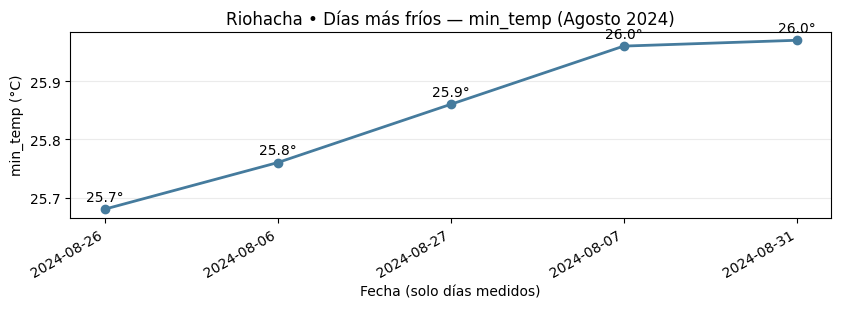

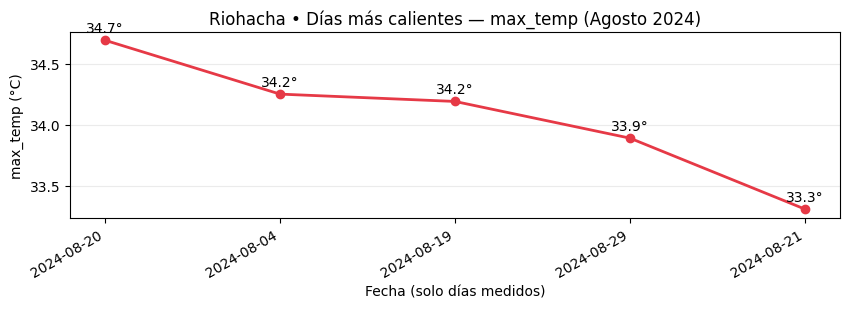

In [11]:
# === Q7 • Días más fríos y más calientes ===
# ---------- Config ----------
BUCKET = "etlt-datalake-dev-us-east-1-gold"
BASE   = f"s3://{BUCKET}/openweather/answers/q7_temp_extremes"
CITIES = ["Patagonia", "Riohacha"]
YEAR, MONTH = 2024, 8

# Paleta para gráficos
COLORS = {
    "cold": "#457b9d",  # azul
    "hot":  "#e63946",  # rojo
}

def load_q7(kind: str):  # "coldest_topk" | "hottest_topk"
    frames = []
    for city in CITIES:
        path = f"{BASE}/{kind}/city_name={city}/year={YEAR}/month={MONTH}/"
        df = pd.read_parquet(path)
        df["city"] = city
        df["kind"] = "Más fríos" if "coldest" in kind else "Más calientes"
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# ---------- Carga ----------
cold = load_q7("coldest_topk")
hot  = load_q7("hottest_topk")
q7   = pd.concat([cold, hot], ignore_index=True)

# ---------- Normalización de fecha ----------
date_src = "event_date" if "event_date" in q7.columns else ("date" if "date" in q7.columns else None)
if date_src is None:
    raise SystemExit("No encuentro columna de fecha (event_date/date) en Q7.")
q7["date"] = pd.to_datetime(q7[date_src], errors="coerce").dt.date

# columnas redundantes y evita duplicados
drop_cols = []
if "event_date" in q7.columns and date_src != "event_date":
    drop_cols.append("event_date")
q7 = q7.drop(columns=drop_cols)
q7 = q7.loc[:, ~q7.columns.duplicated(keep="last")]

# ---------- Renombrados amigables ----------
rename_map = {"avg_clouds":"clouds_avg", "precip_1d_sum":"precip_sum"}
q7 = q7.rename(columns={k:v for k,v in rename_map.items() if k in q7.columns})

# ---------- Helpers ----------
def uniq(seq):
    return list(dict.fromkeys(seq))

def style_q7_table(df, title, mode):
    """
    mode: 'cold' o 'hot' para el gradiente principal.
    SIN fondos/barras en 'clouds_avg' ni 'precip_sum'.
    """
    df = df.copy()
    df = df.loc[:, ~df.columns.duplicated(keep="first")].reset_index(drop=True)

    fmt = {"date": lambda d: pd.to_datetime(d).strftime("%Y-%m-%d")}
    if "rps_day" in df.columns:    fmt["rps_day"] = "{:.3f}"
    if "min_temp" in df.columns:   fmt["min_temp"] = "{:.1f}"
    if "max_temp" in df.columns:   fmt["max_temp"] = "{:.1f}"
    if "clouds_avg" in df.columns: fmt["clouds_avg"] = "{:.0f}%"
    if "precip_sum" in df.columns: fmt["precip_sum"] = "{:.1f}"

    sty = df.style.set_caption(title).format(fmt)

    # Gradientes principales
    if mode == "cold" and "min_temp" in df.columns:
        sty = sty.background_gradient(subset=["min_temp"], cmap="Blues_r")
    if mode == "hot" and "max_temp" in df.columns:
        sty = sty.background_gradient(subset=["max_temp"], cmap="Reds")
    if "rps_day" in df.columns:
        sty = sty.background_gradient(subset=["rps_day"], cmap="Greens")

    if "coverage_quality" in df.columns:
        cov_colors = {
            "good":"background-color:#b7e4c7; color:black; font-weight:600;",
            "ok":"background-color:#ffe8a1; color:black; font-weight:600;",
            "low":"background-color:#f8d7da; color:black; font-weight:600;",
        }
        def cov_style(col):
            return [cov_colors.get(str(v).lower(), "") for v in col]
        sty = sty.apply(cov_style, subset=["coverage_quality"])


    cols_colored = [c for c in ["min_temp","max_temp","rps_day","coverage_quality"] if c in df.columns]
    if cols_colored:
        sty = sty.set_properties(subset=cols_colored, **{"color":"black","font-weight":"600"})
    return sty

def plot_extremes_line(df_dates, values, title, ylabel, color):
    dates_ser = pd.to_datetime(pd.Series(df_dates), errors="coerce")
    x = list(range(len(dates_ser)))
    labels = dates_ser.dt.strftime("%Y-%m-%d").tolist()
    y = values

    plt.figure(figsize=(8.6,3.2))
    plt.plot(x, y, marker="o", linewidth=2.0, color=color)
    for xi, yi in zip(x, y):
        plt.annotate(f"{yi:.1f}°", (xi, yi), xytext=(0,6), textcoords="offset points", ha="center")
    plt.title(title)
    plt.xlabel("Fecha (solo días medidos)")
    plt.ylabel(ylabel)
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# ---------- Salida por ciudad ----------
for city in CITIES:
    sub = q7[q7["city"]==city].copy()

    cols_base = ["rps_day","clouds_avg","precip_sum","coverage_quality"]

    cold_tbl_cols = uniq(["date","min_temp"] + [c for c in cols_base if c in sub.columns])
    hot_tbl_cols  = uniq(["date","max_temp"] + [c for c in cols_base if c in sub.columns])

    cold_tbl = (sub[sub["kind"]=="Más fríos"][cold_tbl_cols]
                .dropna(subset=["min_temp"])
                .sort_values("min_temp", ascending=True)
                .reset_index(drop=True))
    hot_tbl  = (sub[sub["kind"]=="Más calientes"][hot_tbl_cols]
                .dropna(subset=["max_temp"])
                .sort_values("max_temp", ascending=False)
                .reset_index(drop=True))

    display(style_q7_table(cold_tbl, f"{city} • Días más fríos (Agosto {YEAR})", mode="cold"))
    display(style_q7_table(hot_tbl,  f"{city} • Días más calientes (Agosto {YEAR})", mode="hot"))

    # Gráficas sin huecos
    if not cold_tbl.empty:
        plot_extremes_line(
            df_dates=cold_tbl["date"],
            values=cold_tbl["min_temp"].values,
            title=f"{city} • Días más fríos — min_temp (Agosto {YEAR})",
            ylabel="min_temp (°C)",
            color=COLORS["cold"]
        )
    if not hot_tbl.empty:
        plot_extremes_line(
            df_dates=hot_tbl["date"],
            values=hot_tbl["max_temp"].values,
            title=f"{city} • Días más calientes — max_temp (Agosto {YEAR})",
            ylabel="max_temp (°C)",
            color=COLORS["hot"]
        )

RESULTADOS:

* Patagonia:
  
  - Días más fríos (min_temp): 2024-08-24 (−5.8 °C), 08-27 (−4.6 °C), 08-16 (−4.5 °C), 08-18 (−4.2 °C), 08-22 (−4.0 °C).
  - rps_day en estos días: ~0.11–0.18 (moderado a bajo).
  - Nubosidad baja-media y precipitación casi nula en la mayoría.

  - Días más calientes (max_temp): 2024-08-31 (14.4 °C), 08-30 (13.8 °C), 08-12 (13.7 °C), 08-13 (12.2 °C), 08-09 (12.1 °C).
  - rps_day variado: desde ~0.12 hasta 0.204 (08-09).

- En invierno austral, el RPS no escala linealmente con la temperatura; la señal dominante sigue siendo el viento, con algo de penalización por nubosidad cuando sube.
- Covertura: good en todas las filas, por lo tanto, lectura confiable.

* Riohacha:

  - Días más “fríos” (mínimas altas tropicales): 2024-08-26 (25.7 °C), 08-06 (25.8 °C), 08-27 (25.9 °C), 08-07 (26.0 °C), 08-31 (26.0 °C).
  - Muchas de esas noches/franjas vienen con lluvia (hasta 29 mm el 08-31) y nubosidad > 60 %. rps_day oscila 0.18–0.41.

  - Días más calientes (máximas): 2024-08-20 (34.7 °C), 08-04 (34.2 °C), 08-19 (34.2 °C), 08-29 (33.9 °C), 08-21 (33.3 °C).
  - rps_day alto en el top: 0.62–0.64 con nubosidad moderada (10–48 %) y casi sin lluvia, lo que indica condiciones favorables para renovables (solar fuerte + viento útil).

- Los días más calientes y secos suelen coincidir con RPS alto. Atención a mínimos con lluvia: suelen traer RPS menor.
- Covertura: good en todas las filas, por lo tanto, lectura confiable.